# Binary-Contamination Flagging

This notebook demonstrates how to use [grismconf](https://github.com/npirzkal/GRISMCONF) to identify pixels in a grism image that have flux from multiple sources (see [Pirzkal & Ryan (2017)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf) for a detailed description and motivation).  In the simplest terms, this can be used to mask pixels whose flux is ***contaminated***, however a more complex treatment of the overlapping pixels is the foundation of [pyLINEAR](https://github.com/Russell-Ryan/pyLINEAR) and described by [Ryan, Casertano, & Pirzkal (2018)](https://ui.adsabs.harvard.edu/abs/2018PASP..130c4501R/abstract).

## Author:
[Russell Ryan](mailto:rryan@stsci.edu) 
May 14, 2020


## Algorithm:

1.  For each segmentation region:
    1.  Transform the pixels associated with a segmentation region from the rectified coordinate system to the distorted coordinate system on the grism image.
    2.  Disperse these pixels for an array of wavelengths contained in the grism sensitivity curve.  Results in many more pixels than we started with.
    3.  Collect the dispersed, transformed pixels and compute their [convex hull](https://en.wikipedia.org/wiki/Convex_hull).
    4.  Put the vertices from the convex hull into a ```shapely.geometry.Polygon``` object.
2.  Compute the polygon of overlap between two polygons using the method ```intersection``` (returns another ```shapely.geometry.Polygon```
3.  If the ```area``` field of the resultant polygon is larger than a threshold, then the polygons overlap --- meaning there is contamination.
4.  Loop over all combinations of polygons, compute their intersections, and set the pixels *inside* the overlapping polygon as 1 in a contamination image.  This is performed by creating a lattice of all (x,y) pairs with ```shapely.geometry.MultiPoint``` and checking for intersections between the overlapping polygon and the lattice.

**This algorithm was taken from the [pyLINEAR](https://github.com/Russell-Ryan/pyLINEAR) toolkit for grouping sources that overlap in a grism image.**

## Supporting Data:

This requires two sets of ancillary files that should be placed in directories with appropriate names next to this python notebook

| purpose | location | directory name |
|:------- |:---------|:---------|
| grism reference files | [for G141](https://github.com/npirzkal/GRISM_WFC3) | config |
| test data | box directory | test_data |



## Dependencies:

Other than the usual things (like numpy, scipy, astropy, and matplotlib), you will need a few specialized modules:

| package  | install  | description  |
|:---|:---|:---|
| [grismconf](https://github.com/npirzkal/GRISMCONF) | ```pip install grismconf```   | to perform grism dispersion and pixel transformations  |
| [shapely](https://shapely.readthedocs.io/en/latest/manual.html) | ```pip install shapely``` | to perform computational geometry, including intersection of polygons |

Versions used in preparing this notebook.

| package | version |
|:--- | --- |
| python | 3.7.7 |
| numpy | 1.18.1 |
| scipy | 1.4.1 |
| matplotlib | 3.1.3 |
| astropy | 4.0.1.post1 |
| shapely | 1.7.0 |

In [1]:
import numpy as np
from scipy.spatial import ConvexHull
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import os
from shapely import geometry
import grismconf

In [2]:
# some variables that will be used below
segfile = 'seg.fits'       # segmentation image
imgfile = 'img.fits'       # direct image file
dataset = 'icc905meq'      # an example grism dataset (from WFC3-IR here)
conffile = 'g141.conf'     # grism config file
lamb0 = 10700.             # starting wavelength to consider (in A)
lamb1 = 16900.             # ending wavelength to consider (in A)
dlamb = 200.               # wavelength resolution to consider (in A)
order = '+1'               # beam order to use
minarea = 0.1              # area threshold to consider a spectral collision (in pixels)

### Just create to objects that we will use over and over

In [3]:
# just create a wavelength grid to use
lamb = np.arange(lamb0,lamb1+dlamb,dlamb)

# load the grism reference file
config = grismconf.Config(os.path.join('config',conffile))

### Create two helper functions that will be useful

In [4]:
def compute_vertices(x,y):
    ''' Convenience function to compute convex hull vertices '''

    # consider the full range of a pixel
    dx=np.array([0,0,1,1])
    dy=np.array([0,1,1,0])
      
    # group the pixels (top,bottom,left,right) into a list of tuples
    xy=[]
    for ddx,ddy in zip(dx,dy):
        xx=x+ddx
        yy=y+ddy
        xy.extend(list(zip(xx,yy)))

    # convert to a 2xN numpy array
    xy=np.array(list(set(xy)))

    # compute the jhull
    hull=ConvexHull(xy)
    
    # just get the vertices of the hull
    xh,yh=[],[]
    for vertex in hull.vertices:
        xh.append(xy[vertex,0])
        yh.append(xy[vertex,1])
    
    # return the vertices as numpy arrays
    xh,yh=np.array(xh),np.array(yh)

    return xh,yh   

In [5]:
def load_imaging(filename,exten=0):
    ''' convenience function to read image and return data and WCS object '''
    with fits.open(os.path.join('test_data',filename)) as hdul:
        hdu = hdul[exten]
        img = hdu.data           # numpy.ndarray as an image
        wcs = WCS(hdu.header)    # WCS object
    return img,wcs

### Load the images and WCS

In [6]:
# read the data
seg,segwcs = load_imaging(segfile)
img,imgwcs = load_imaging(imgfile)
flt,fltwcs = load_imaging(dataset+'_flt.fits', exten=1)

# find the unique segmentation IDs
segids,indices,counts = np.unique(seg, return_inverse=True, return_counts=True)
pixel_list = np.split(np.argsort(indices), np.cumsum(counts[:-1]))

# but let's remove the zeroth index, as that corresponds to where the segmentation 
# map has a value of 0, which is associated with the sky
segids = np.delete(segids,0)
del pixel_list[0]

# now segids is a list of unique segmentation IDs and pixel_list is the list 
# of pixels that belong to each of those IDs.  The catch is... the pixel_list
# represent the 1d image coordinates, so need to use divmod to find the (x,y) pair

### Find the unique segmentation ID and their pixels

In [7]:
# find the unique segmentation IDs
segids,indices,counts = np.unique(seg, return_inverse=True, return_counts=True)
pixel_list = np.split(np.argsort(indices), np.cumsum(counts[:-1]))

# but let's remove the zeroth index, as that corresponds to where the segmentation 
# map has a value of 0, which is associated with the sky
segids = np.delete(segids,0)
del pixel_list[0]

# now segids is a list of unique segmentation IDs and pixel_list is the list 
# of pixels that belong to each of those IDs.  The catch is... the pixel_list
# represent the 1d image coordinates, so need to use divmod to find the (x,y) pair

### Disperse each source and package into a Polygon object

In [8]:
# disperse the pixels associated with each source and make into a shapely polygon

polys = {}       # will be a dictionary of polygons (key is the SEGID)
for segid, pixels in zip(segids,pixel_list):
    # parse the 1d image coordinates to 2d (x,y) pairs
    y,x = np.divmod(pixels,seg.shape[1])
     
    # transform the coordinates from the direct image to the FLT image using WCS
    a,d = segwcs.all_pix2world(x,y,0)
    xg,yg = fltwcs.all_world2pix(a,d,0)

    # figure out where each pixel goes as a function of our wavelengths
    # incidentally, these will be all the relevant grism pixels associated with a 
    # given object at all relevant wavelengths.  collect those pixels in these lists:
    xgrism,ygrism = [],[]
    for xx,yy in zip(xg,yg):
        # compute the parameter 't' for the wavelength
        t = config.INVDISPL(order,xx,yy,lamb)
       
        # compute the wavelength dependent position using the parameter
        xl = config.DISPX(order,xx,yy,t) + xx
        yl = config.DISPY(order,xx,yy,t) + yy
         
        # collect those pixels
        xgrism.extend(xl)
        ygrism.extend(yl)
        
    # now with all the pixels projected forward as a function of wavelength, compute 
    # the convex hull associated with those (ie. the maximum outer surface)
    xh,yh = compute_vertices(np.array(xgrism),np.array(ygrism))
        
    # now those form the vertices of a shapely polygon. But shapely is expecting 
    # a list of tuples
    xyh = list(zip(xh,yh))
    poly = geometry.Polygon(xyh)
    
    # record the polygon
    polys[segid] = poly        

### Just view one polygon

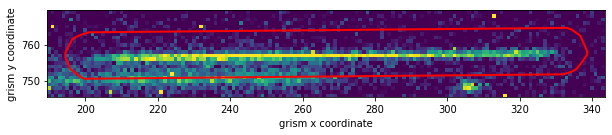

In [9]:
# let's look at one of those polygons
showid=1200            # segid to view

# create a plot window
fig,p1=plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
p1.imshow(flt,origin='lower',vmin=0,vmax=0.3)
_ = p1.plot(*polys[showid].exterior.coords.xy,linewidth=2,color='red')

# set the labels
plt.xlabel('grism x coordinate')
plt.ylabel('grism y coordinate')

# compute a bounding box for setting plot range
minx, miny, maxx, maxy = polys[showid].bounds
_ = p1.set_xlim(minx-5,maxx+5)
_ = p1.set_ylim(miny-5,maxy+5)

### Check if two polygons overlap/intersect

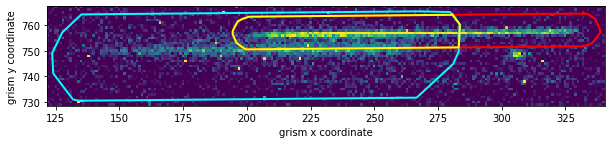

In [10]:
# now can trivially see if two polygons overlap using shapely methods
poly1 = polys[1182]     # pick one polygon to test
poly2 = polys[1200]     # just pick a differnt polygon
contam_poly = poly1.intersection(poly2)

# show the image and draw the two polygons
fig,p1 = plt.subplots(1,1,figsize=(10,10),sharex=True,sharey=True)
p1.imshow(flt,origin='lower',vmin=0,vmax=0.3)
    
p1.plot(*poly1.exterior.coords.xy,color='cyan',linewidth=2)
p1.plot(*poly2.exterior.coords.xy,color='red',linewidth=2)

# get the bounding box and zoom (a bit tighter than last time)
minx1, miny1, maxx1, maxy1 = poly1.bounds
minx2, miny2, maxx2, maxy2 = poly2.bounds
p1.set_xlim(min(minx1,minx2)-2,max(maxx1,maxx2)+2)
p1.set_ylim(min(miny1,miny2)-2,max(maxy1,maxy2)+2)

# set the labels
plt.xlabel('grism x coordinate')
plt.ylabel('grism y coordinate')


# if the two input polygons overlap, then there is assuredly contamination
if contam_poly.area > minarea:
    # draw the overlapping polygon
    p1.plot(*contam_poly.exterior.coords.xy,color='yellow',linewidth=2)
else:
    print("Spectral Traces do not overlap")

# note: the cyan region is with polygon1, the red region is polygon2, and the yellow
# is for the overlapping polygon.

### Check all unique pairs of polygons for overlaps/intersections

In [11]:
# I knew the above would collide, so let's consider all possible combinations to build 
# a mask image indicating which pixels are contaminated.

# create a lattice of points (this is kinda slow)
# this could be sped up, by computing the full range of all the Polygons.
x = np.arange(flt.shape[1])
y = np.arange(flt.shape[0])
lattice = geometry.MultiPoint(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))

# a message for printing
message = '{0:4d} and {1:4d} overlap by {2:6.1f} grism-image pixels'
xy = []        # a list of tuples containing the pixels that have overlaps
for segid1,traces1 in polys.items():
    for segid2,traces2 in polys.items():
        # if segid1 overlaps with segid2, then segid2 overlaps segid1.  Therefore,
        # let's only check one of those.  Also, segid1 will overlap segid1, so avoid that.
        if segid1 < segid2:
            # compute the intersection of two traces
            p = traces1.intersection(traces2)
            
            # they will overlap if the area of the intersection is positive
            if p.area > minarea:
                # this is kinda slow
                print(message.format(segid1,segid2,p.area))

                # look for pixels *inside* the overlap by intersecting against a lattice
                result = lattice.intersection(p)
                
                # check that the intersection of the lattice has many points.
                # there is a corner case here, where if it returns a single point
                # so it's easy to consider the other case(s) as well.
                if isinstance(result,geometry.MultiPoint):
                    
                    # get the pixels pairs that are in the resultant lattice
                    tmp = [(int(pix.x),int(pix.y)) for pix in result]
                        
                    # aggregate with the full list
                    xy.extend(tmp)

1032 and 1149 overlap by   87.3 grism-image pixels
1032 and 1181 overlap by   45.2 grism-image pixels
1137 and 1181 overlap by  324.8 grism-image pixels
1142 and 1174 overlap by  288.7 grism-image pixels
1142 and 1180 overlap by  413.2 grism-image pixels
1154 and 1158 overlap by  785.2 grism-image pixels
1154 and 1192 overlap by  145.3 grism-image pixels
1154 and 1242 overlap by   55.0 grism-image pixels
1158 and 1182 overlap by    7.1 grism-image pixels
1158 and 1190 overlap by   55.7 grism-image pixels
1158 and 1242 overlap by   85.0 grism-image pixels
1159 and 1186 overlap by  550.1 grism-image pixels
1159 and 1192 overlap by  338.6 grism-image pixels
1160 and 1161 overlap by 1664.7 grism-image pixels
1160 and 1182 overlap by  473.2 grism-image pixels
1160 and 1184 overlap by 1589.3 grism-image pixels
1160 and 1200 overlap by  429.9 grism-image pixels
1160 and 1226 overlap by  339.4 grism-image pixels
1161 and 1182 overlap by  661.2 grism-image pixels
1161 and 1184 overlap by 1488.3

### convert the list of (x,y) tuples into a 2d contamination mask

In [12]:
# now take the pixels and put them in the contamination image
x,y = list(zip(*xy))
x = np.array(x)
y = np.array(y)

# the 2d contam mask
contam = np.zeros_like(flt,dtype=np.uint8)     # the output image
contam[y,x] = 1

### Plot the 2d Contamination mask

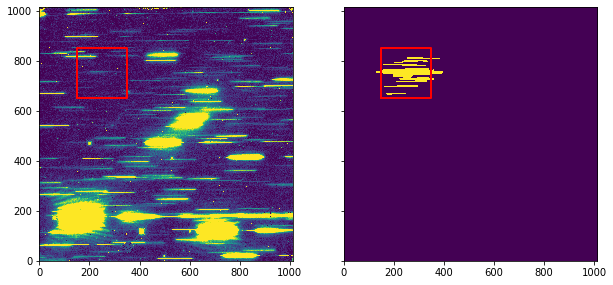

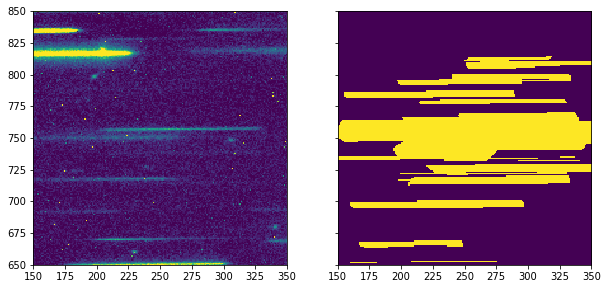

In [13]:
# set the bounding box for where we will zoom to
xmin,xmax = 150,350
ymin,ymax = 650,850

# well... we went through the trouble to make the 2d image, let's at least look at it
fig,(p1,p2) = plt.subplots(1,2,figsize=(10,10),sharex=True,sharey=True)
fig,(p3,p4) = plt.subplots(1,2,figsize=(10,10),sharex=True,sharey=True)

# show the FLT full and zoom frame
p1.imshow(flt,origin='lower',vmin=-0.05,vmax=0.7)
p3.imshow(flt,origin='lower',vmin=-0.05,vmax=0.7)

# show the contam full and zoom
p2.imshow(contam,origin='lower',vmin=0,vmax=1)
p4.imshow(contam,origin='lower',vmin=0,vmax=1)

# zoom to an interesting region
_ = p3.set_xlim(xmin,xmax)
_ = p3.set_ylim(ymin,ymax)

# show where the zooms are on the original image
_ = p1.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],color='red',linewidth=2)
_ = p2.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],color='red',linewidth=2)

# Please note.  The segmentation image used here was much smaller than the FLT.  
# Therefore, there are many sources whose contaminating effects are not considered.

### Caveats of the Above
1.  **Orphaned Regions:** We have tacitly assumed that no segmentation IDs are orphaned: that every pixel associated with a given segementation ID is connected.  However if that is not true, the algorithm implemented here may represent an overly conservative way of masking.  One should consider identifying island segmentation regions and propagate them through the same algorithm described above.  This problem is exacerbated for regions that have significant overlap.
2.  **Contamination Image:** The algorithm to create a contamination image is somewhat slow because it requires computing the point(s) inside a polygon.  There might be better ways with shapley to do this and/or one might consider if rendering a 2d contamination image is truely needed.

### Items for Additional Consideration
1.  **Performance:** The performance can be improved by changing the dispersion philosophy.  Here, we have dispersed every pixel associated with every source at every wavelength to populate the trace.  This is what is done with [pyLINEAR](https://github.com/Russell-Ryan/pyLINEAR) since the goal is to extract the spectral trace.  But if the goal is to ***only*** determine contamination flags, then one could instead compute the convex hull of the *direct* image and disperse that.  For large sources, this would represent a significant improvement, but only modest for compact sources.

2.  **Fractional vs. Binary Contamination:** Here the contamination is given as a binary flag, but one could build in more terms to estimate fractional contamination.  This would require implementing the sensitivity function, flat field model, spectrum of the source, propagating the relative brightnesses of the direct image pixels, and computing some fractional pixel overlap.  However, one typically does not know the spectrum of the source *a priori*.  [pyLINEAR](https://github.com/Russell-Ryan/pyLINEAR) solves the full suite of linear equations to simultaneously extract the spectrum of every source while accounting for the fractional contamination.

3.  **Toward a Predictive Model and Proposal Preparation:** We have explicitly assumed that an FLT image exists, but this may not always be the case.  In principle, the FLT image pixel values are never used to estimate contamination, but only for visualization.  Therefore, if one can programmatically obtain a WCS for an equivalent FLT, then the contamination can be predict *before* the grism data were actually observed.  Hence, this notebook can be slightly modified to predict contamination for a possible observation set-up and a user can gerrymander their observational setup (dither, orients, etc.) to avoid pathological regions in the detector and/or contamination.

4.  **Overly Optimistic:** We have explicitly only considered pixels associated with a segmentation map, which may be too small.  Therefore, one might consider *growing* the segmentation map and/or the dispersed polygon.  Additionally, we have only treated `+1` orders, and in principle, one might worry about higher/lower orders.